### Libraries

In [76]:
import numpy as np
import datajoint as dj
import pandas as pd
import pygsheets
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure


### Connect to database

In [31]:
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
#dj.config['database.user'] = 'alvaros'

conn = dj.conn(host=dj.config['database.host'], user=dj.config['database.user'])
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
behavior = dj.create_virtual_module('behavior', 'u19_behavior')


session_columns = ['subject_fullname', 'session_date', 'session_number', 'session_start_time', 'session_end_time', 'session_protocol']
session_trial_columns = ['subject_fullname', 'session_date', 'session_number', 'trial_time']


### Get crash dates

In [32]:

# Order dates
crash_dates_df = pd.read_csv('session_crash_dates_rig1.csv', header=0, names=['crash_date_str'])
crash_dates_df['crash_date'] = pd.to_datetime(crash_dates_df['crash_date_str'])
crash_dates_df = crash_dates_df.sort_values(by=['crash_date'])
crash_dates_df = crash_dates_df.reset_index(drop=True)
# Get first and last date from list (add and substract 3 days to )
first_date = crash_dates_df.loc[0,'crash_date']  -  pd.to_timedelta(1, unit='d')
first_date = first_date.strftime("%Y-%m-%d %H:%M:%S")
last_date  = crash_dates_df.loc[crash_dates_df.shape[0]-1,'crash_date']  +  pd.to_timedelta(1, unit='d')
last_date =  last_date.strftime("%Y-%m-%d %H:%M:%S")


crash_dates_df['session_id'] = -1
crash_dates_df['diff_hours'] = None


crash_dates_df

,crash_date_str,crash_date,session_id,diff_hours
0,2020-09-01 08:26:31,2020-09-01 08:26:31,-1,None
1,2020-09-03 16:03:11,2020-09-03 16:03:11,-1,None
2,2020-09-10 10:52:15,2020-09-10 10:52:15,-1,None
3,2020-09-25 13:00:50,2020-09-25 13:00:50,-1,None
4,2020-09-28 12:58:23,2020-09-28 12:58:23,-1,None
5,2020-10-06 08:32:23,2020-10-06 08:32:23,-1,None
6,2020-10-17 07:43:27,2020-10-17 07:43:27,-1,None
7,2020-10-26 12:34:12,2020-10-26 12:34:12,-1,None
8,2020-10-27 07:03:05,2020-10-27 07:03:05,-1,None
9,2020-10-27 22:48:56,2020-10-27 22:48:56,-1,None


### Get sessions from dates 

In [105]:
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')

key = {'session_location': 'TrainVR1'}
date_key = "session_date >= '" + first_date + "' and session_date <= '" + last_date + "'"

sessions = acquisition.Session & key & date_key
sessions_df = pd.DataFrame(sessions.fetch())
sessions_df = sessions_df[session_columns]
sessions_df['session_start_time'] = pd.to_datetime(sessions_df['session_start_time'])
sessions_df = sessions_df.sort_values(by=['session_start_time'])
sessions_df = sessions_df.reset_index(drop=True)
sessions_df['session_date'] = sessions_df['session_date'].astype(str)
sessions_df['session_number'] = sessions_df['session_number'].astype(str)
sessions_df

,subject_fullname,session_date,session_number,session_start_time,session_end_time,session_protocol
0,sbolkan_test,2020-09-01,0,2020-09-01 07:53:00,2020-09-01 15:21:00,poisson_patchesAndPuff_laserTTL.m poisson_bloc...
1,gps1,2020-09-11,0,2020-09-11 11:21:00,2020-09-11 12:13:00,poisson_blocks.m poisson_blocks_reboot_3m.mat ...
2,gps1,2020-09-12,0,2020-09-12 10:27:00,2020-09-12 11:15:00,poisson_blocks.m poisson_blocks_reboot_3m.mat ...
3,gps1,2020-09-13,0,2020-09-13 10:23:00,2020-09-13 11:41:00,poisson_blocks.m poisson_blocks_reboot_3m.mat ...
4,gps1,2020-09-14,0,2020-09-14 10:27:00,2020-09-14 11:43:00,poisson_blocks.m poisson_blocks_reboot_3m.mat ...
...,...,...,...,...,...,...
254,jjulian_jj007,2020-11-20,0,2020-11-20 12:38:00,2020-11-20 13:39:00,josh_poisson_blocks_noTowers_TTL.m josh_poisso...
255,sbolkan_d1_1279,2020-11-21,0,2020-11-21 08:35:00,2020-11-21 09:44:00,poisson_blocks_laser_scott.m poisson_blocks_Pr...
256,sbolkan_a2a_401,2020-11-21,0,2020-11-21 10:10:00,2020-11-21 11:18:00,poisson_blocks_laser_scott.m poisson_blocks_Pr...
257,jjulian_jj007,2020-11-21,0,2020-11-21 11:51:00,2020-11-21 12:59:00,josh_poisson_blocks_noTowers_TTL.m josh_poisso...


### Get closest sessions to crash

In [106]:
# Get sessions that started 5 hours before crash
for i in range(crash_dates_df.shape[0]):
    session_diff_time = crash_dates_df.loc[i, 'crash_date'] - sessions_df['session_start_time']    
    session_diff_time = session_diff_time.dt.total_seconds()
    session_diff_time = session_diff_time.loc[(session_diff_time > 0) & (session_diff_time < (3600*10))]
    #session_diff_time = session_diff_time.loc[(session_diff_time > 0)]
    if session_diff_time.shape[0] > 0:
        crash_dates_df.loc[i, 'session_id'] = session_diff_time.tail(1).index.values[0]
        crash_dates_df.loc[i, 'diff_min'] = session_diff_time.tail(1).values[0]/60

# Filter crashes close to sessions 
crash_dates_df2 = crash_dates_df.loc[crash_dates_df['session_id'] >= 0, :]
crash_dates_df2 = crash_dates_df2.reset_index(drop = True)        
        
# Filter session dataframe close to crashes
sel_sessions = crash_dates_df['session_id'][crash_dates_df['session_id'] >= 0]  
sel_sessions_df = sessions_df.loc[sel_sessions, :]
sel_sessions_df = sel_sessions_df.reset_index(drop = True)

#Extra columns for session dataframe
sel_sessions_df['crash_date'] = crash_dates_df2['crash_date']
sel_sessions_df['diff_min_start'] = crash_dates_df2['diff_min']
sel_sessions_df['diff_min_end'] = sel_sessions_df['crash_date'] - sel_sessions_df['session_end_time']
sel_sessions_df['diff_min_end'] = sel_sessions_df['diff_min_end'].dt.total_seconds()/60
sel_sessions_df['crash_during_session'] = 0
sel_sessions_df.loc[(sel_sessions_df['diff_min_start'] > 0) & \
                    (sel_sessions_df['diff_min_end'] < 0),['crash_during_session']] = 1
sel_sessions_df['key'] = "('" + sel_sessions_df['subject_fullname'] + "','" \
                              + sel_sessions_df['session_date'] + "'," \
                              + sel_sessions_df['session_number'] + ")"



#Filter sessions that ended session max 10 minutes before crash
#sel_sessions_df = sel_sessions_df.loc[sel_sessions_df['diff_min_end'] <= 10, :]


sel_sessions_df
#sel_sessions_df.loc[0,['session_protocol']].values.tolist()

,subject_fullname,session_date,session_number,session_start_time,session_end_time,session_protocol,crash_date,diff_min_start,diff_min_end,crash_during_session,key
0,sbolkan_test,2020-09-01,0,2020-09-01 07:53:00,2020-09-01 15:21:00,poisson_patchesAndPuff_laserTTL.m poisson_bloc...,2020-09-01 08:26:31,33.516667,-414.483333,1,"('sbolkan_test','2020-09-01',0)"
1,gps1,2020-09-25,0,2020-09-25 11:52:00,2020-09-25 12:52:00,poisson_blocks.m poisson_blocks_reboot_3m.mat ...,2020-09-25 13:00:50,68.833333,8.833333,0,"('gps1','2020-09-25',0)"
2,JJ003,2020-09-28,0,2020-09-28 11:52:00,2020-09-28 12:56:00,josh_poisson_blocks.m josh_poisson_blocks_noTo...,2020-09-28 12:58:23,66.383333,2.383333,0,"('JJ003','2020-09-28',0)"
3,JJ003,2020-10-26,0,2020-10-26 11:48:00,2020-10-26 12:32:00,josh_poisson_blocks.m josh_poisson_blocks_noTo...,2020-10-26 12:34:12,46.200000,2.200000,0,"('JJ003','2020-10-26',0)"
4,jounhong_DAT779,2020-10-27,0,2020-10-27 14:42:00,2020-10-27 15:42:00,poisson_patches_laserTTL_Ryan_CueRegion_Phasic...,2020-10-27 22:48:56,486.933333,426.933333,0,"('jounhong_DAT779','2020-10-27',0)"
5,jounhong_DAT779,2020-11-02,0,2020-11-02 14:45:00,2020-11-02 15:23:00,poisson_patches_laserTTL_Ryan_CueRegion_Phasic...,2020-11-02 15:23:21,38.350000,0.350000,0,"('jounhong_DAT779','2020-11-02',0)"
6,sbolkan_a2a_401,2020-11-11,0,2020-11-11 09:44:00,2020-11-11 10:44:00,poisson_blocks_laser_scott.m poisson_blocks_Pr...,2020-11-11 11:06:48,82.800000,22.800000,0,"('sbolkan_a2a_401','2020-11-11',0)"
7,jjulian_jj007,2020-11-20,0,2020-11-20 12:38:00,2020-11-20 13:39:00,josh_poisson_blocks_noTowers_TTL.m josh_poisso...,2020-11-20 16:15:53,217.883333,156.883333,0,"('jjulian_jj007','2020-11-20',0)"


### Query trials for selected sessions

In [107]:

key_sel_sessions = ",".join(sel_sessions_df['key'].values.tolist())
query_sel_sessions = 'select * from u19_behavior._towers_block__trial ' + \
                     'WHERE (subject_fullname, session_date, session_number)' + \
                     ' IN ( ' +  key_sel_sessions + ')'
sel_sessions_key = '(subject_fullname, session_date, session_number)' + \
                     ' IN ( ' +  key_sel_sessions + ')'

trials_sessions = behavior.TowersBlock.Trial & sel_sessions_key
trials_sessions_df = pd.DataFrame(trials_sessions.fetch())

trials_sessions_df.shape

(1417, 32)

In [108]:

trials_sessions_df['freq_rate'] = trials_sessions_df['trial_time'].apply(lambda x: np.diff(x.flatten()))
trials_sessions_df['freq_rate'] = trials_sessions_df['freq_rate'].apply(lambda x: x.tolist())

trials_sessions_df2 = trials_sessions_df.loc[:,['subject_fullname', 'session_date', 'session_number', 'freq_rate']]
group_session_df    = trials_sessions_df2.groupby(by=['subject_fullname', 'session_date', 'session_number']).sum()

group_session_df = group_session_df.reset_index()

group_session_df['freq_rate'] = group_session_df['freq_rate'].apply(lambda x: np.array(x))
trials_sessions_df2['freq_rate'] = trials_sessions_df2['freq_rate'].apply(lambda x: np.array(x))

group_session_df['mean_rate'] = group_session_df['freq_rate'].apply(lambda x: np.mean(x))
trials_sessions_df2['mean_rate'] = trials_sessions_df2['freq_rate'].apply(lambda x: np.mean(x))

group_session_df['min_rate'] = group_session_df['freq_rate'].apply(lambda x:  np.min(x))
trials_sessions_df2['min_rate'] = trials_sessions_df2['freq_rate'].apply(lambda x:  np.min(x))

#group_session_df['session_date'] = group_session_df['session_date'].astype(str)
#group_session_df['session_number'] = group_session_df['session_number'].astype(str)

group_session_df = group_session_df.sort_values(by=['session_date'])
group_session_df = group_session_df.reset_index(drop=True)
group_session_df

,subject_fullname,session_date,session_number,freq_rate,mean_rate,min_rate
0,sbolkan_test,2020-09-01,0,"[0.055281199514865875, 0.013202399015426636, 0...",0.015872,0.005348
1,gps1,2020-09-25,0,"[0.055169399827718735, 0.008142102509737015, 0...",0.008824,0.003620
2,JJ003,2020-09-28,0,"[0.058671701699495316, 0.007853295654058456, 0...",0.008846,0.002155
3,jounhong_DAT779,2020-10-27,0,"[0.05761659890413284, 0.009541600942611694, 0....",0.008917,0.004023
4,jounhong_DAT779,2020-11-02,0,"[0.05630000000000002, 0.008941599999999994, 0....",0.008591,0.004085
5,sbolkan_a2a_401,2020-11-11,0,"[0.09091150015592575, 0.03738110512495041, 0.0...",0.040837,0.033203
6,jjulian_jj007,2020-11-20,0,"[0.11358969658613205, 0.012517102062702179, 0....",0.004103,0.002606


### Plot frequency rate by session

JJ003 2020-09-28 0


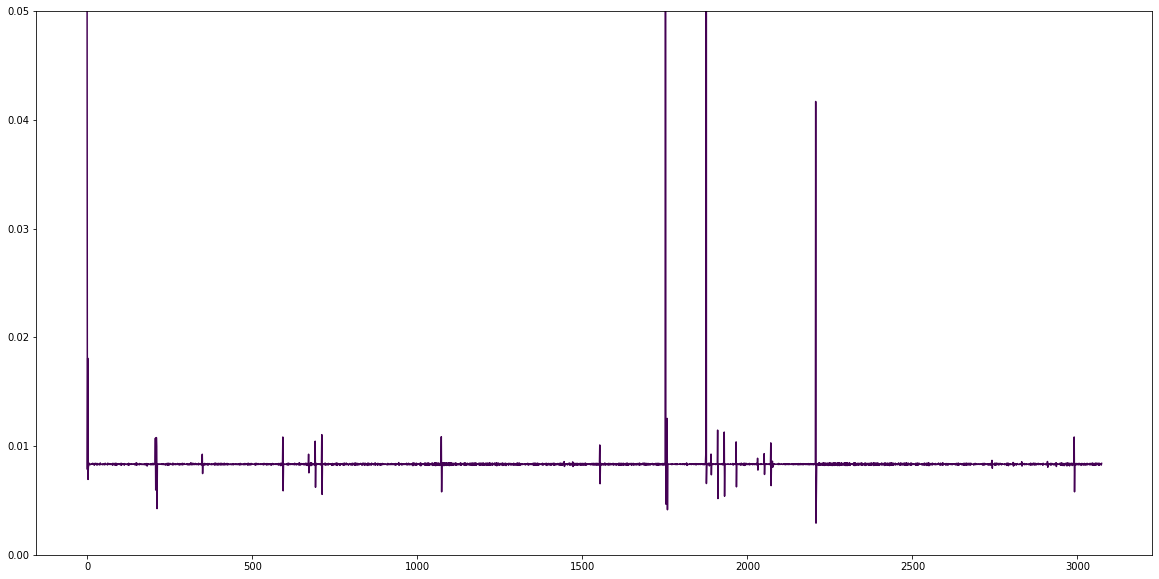

In [112]:
sel_session = 2
subject_fullname = group_session_df.loc[sel_session, 'subject_fullname']
session_date = group_session_df.loc[sel_session, 'session_date']
session_number = group_session_df.loc[sel_session, 'session_number']

print(subject_fullname, session_date, session_number)

figure(figsize=(20,10))
session_plot = trials_sessions_df2.loc[(trials_sessions_df2['subject_fullname'] == subject_fullname) &
                                       (trials_sessions_df2['session_date'] == session_date) &
                                       (trials_sessions_df2['session_number'] == session_number),:]
session_plot = session_plot.reset_index(drop=True)


#viridis = cm.get_cmap('viridis', session_plot.shape[0])
viridis = cm.get_cmap('viridis', 10)
legend_handles = []

#for i in range(session_plot.shape[0]):
for i in range(1):

    color = viridis
    plotted, = plt.plot(session_plot.loc[i, 'freq_rate'], color=viridis(i))
    legend_handles.append(plotted)

ax = plt.gca()    
ax.set_ylim((0, 0.05)) 
#ax.set_xlim((150,250)) 
plt.show()



In [113]:
1/.00833333333333333333

120.0